In [1]:
import glob, os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import string
from tqdm.notebook import tqdm, trange
import datasets
from trdg.generators import GeneratorFromStrings

import tokenizers

def imshow(im, ocv_format=True):
    binary = im.shape[0] == 1
    if ocv_format and not binary:
        im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
    plt.imshow(im, cmap='gray' if binary else None)

def imdisplay(im, ocv_format=True):
    binary = im.shape[0] == 1
    if ocv_format and not binary:
        im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
    display(Image.fromarray(im))

Missing modules for handwritten text generation.


In [2]:
generator = GeneratorFromStrings(['Test1', 'Test2', 'amogus haha'])

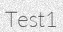

In [3]:
im, text = next(generator)
im

In [4]:
im.size

(63, 32)

In [5]:
wikitext = datasets.load_dataset('wikitext', 'wikitext-103-raw-v1')

In [6]:
def filter_printable(sample):
    text = sample['text']
    return len(text)>0 and all(c in string.printable for c in text)

In [7]:
wikitext = wikitext.filter(filter_printable, num_proc=4)

In [8]:
wikitext['train'][0]

{'text': ' = Valkyria Chronicles III = \n'}

In [11]:
tokenizer = tokenizers.ByteLevelBPETokenizer(add_prefix_space=True)
train_from_scratch = False

In [12]:
def batch_iterator(ds, batch_size=1000):
    for i in range(0, len(ds), batch_size):
        yield ds[i : i + batch_size]["text"]

In [15]:
if train_from_scratch:
    tokenizer.train_from_iterator(
        batch_iterator(wikitext['train']),
        vocab_size=10240,
        min_frequency=2,
        show_progress=True,
        special_tokens=['<pad>', '<s>', '</s>']
    )
    tokenizer.save_model('ckpts/', 'tokenizer')
else:
    tokenizer = tokenizer.from_file('ckpts/tokenizer-vocab.json', 'ckpts/tokenizer-merges.txt')

In [19]:
ids = tokenizer.encode('hello guys, desync here!!').ids
print(ids)
tokenizer.decode(ids)

[260, 901, 81, 1154, 1085, 14, 603, 1953, 69, 4897, 3, 3]


'hello guys, desync here!!'

In [22]:
bos, eos = tokenizer.token_to_id('<s>'), tokenizer.token_to_id('</s>')

In [23]:
def process(sample):
    ids = tokenizer.encode(sample['text']).ids
    ids = [bos] + ids + [eos]
    return { 'ids': ids, 'len': len(ids) }

In [26]:
tokenized = wikitext.map(
    process,
    remove_columns=['text'],
    desc='tokenizing...',
    num_proc=8,
)

tokenizing... (num_proc=8):   0%|          | 0/2272 [00:00<?, ? examples/s]

tokenizing... (num_proc=8):   0%|          | 0/1936 [00:00<?, ? examples/s]

In [27]:
tokenized

DatasetDict({
    test: Dataset({
        features: ['ids', 'len'],
        num_rows: 2272
    })
    train: Dataset({
        features: ['ids', 'len'],
        num_rows: 909837
    })
    validation: Dataset({
        features: ['ids', 'len'],
        num_rows: 1936
    })
})

In [30]:
for split, ds in tokenized.items():
    arr_len = np.sum(ds['len'], dtype=np.int64)
    fname = f'{split}.bin'
    arr = np.memmap(fname, dtype=np.uint16, mode='w+', shape=(arr_len,))
    n_batches = 1024
    idx = 0
    for batch_idx in trange(n_batches, desc=f'writing {fname}'):
        batch = ds.shard(n_batches, batch_idx, True).with_format('numpy')
        arr_batch = np.concatenate(batch['ids'])
        arr[idx:idx+len(arr_batch)] = arr_batch
        idx += len(arr_batch)
    arr.flush()

writing test.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

writing train.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

writing validation.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

In [31]:
import trdg

In [170]:
class TextPicker:
    def __init__(self, ds, n):
        self.ds, self.n = ds, n
        self.total_len = 360854845
        self.it = nword_picker(ds, n)
        # for doc in tqdm(ds):
        #     self.total_len += len(doc['text'])

    def __len__(self):
        return self.total_len

    def __getitem__(self, idx):
        return next(self.it)

    def __iter__(self):
        return nword_picker(self.ds, self.n)

In [205]:
def nword_picker(ds, n):
    for doc in ds:
        words = doc['text'].split()
        for i in range(0, len(words)-n):
            yield ' '.join(words[i:i+n])            

In [206]:
tp = TextPicker(wikitext['train'].shuffle(seed=0), 3)

In [212]:
tp[0]

'Chris Traeger character'

In [220]:
gen = trdg.generators.GeneratorFromStrings(tp)

In [221]:
for im, text in tqdm(gen):
    print(text)
    break

0it [00:00, ?it/s]

Rick Porter of


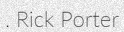

In [222]:
im

In [223]:
import torch
from torch.utils.data import IterableDataset

In [224]:
class SynthDataset(IterableDataset):
    def __init__(self, count, min_len, max_len, filter=None, transform=None):
        super().__init__()
        self.gens = [GeneratorFromDict(length=i, text_color='#000000', image_mode='L') 
            for i in range(min_len, max_len+1)]
        self.filter = filter
        self.transform = transform
        self.count = count

    def __iter__(self):
        def generator():
            k = 0
            while k < self.count:
                gen = random.choice(self.gens)
                im, text = next(gen)
                if filter and not filter(im, text):
                    continue
                if self.transform:
                    im, text = self.transform(im, text)
                yield im, text
                k += 1
        return generator()